In [253]:
import numpy as np
import math
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import copy

In [254]:
class LinUCB():
    def __init__(self, arm, dim=2, lamda = 1, T=1000):
        self.arm = arm
        self.A_t = 0
        self.y = np.zeros((dim, 1))
        self.V = lamda * np.identity(dim)
        self.beta =  1 + np.sqrt(2*np.log(T)+dim*np.log((dim+T)/dim))
        self.actions = []
        
    def observe_reward(self, reward):
        
        self.V = self.V + self.arm[self.A_t].T * self.arm[self.A_t]
        self.y = self.y + self.arm[self.A_t].T * reward
        
        
    def compute(self):
        # estimate theta 
        inv_V = np.linalg.inv(self.V)
        self.hat_theta = inv_V * self.y
        # compute ucb
        ucb = self.arm * self.hat_theta + self.beta * np.matrix(np.diag(np.sqrt( self.arm * inv_V * self.arm.T ))).T
        self.A_t = np.argmax(ucb)
        self.actions.append(self.arm[self.A_t])
        return self.arm[self.A_t]

In [327]:
class UCB:
    def __init__(self, action_set, dim=2, T=1000):
        self.arm = action_set
        self.T = T
        self.alpha = 1/(T*T)
        self.sample_means = np.asarray([0.0] * len(action_set))
        self.confidence_widths = np.asarray([np.inf] * len(action_set))
        self.num_pulls = np.asarray([0] * len(action_set))
        self.actions = []
        self.action_idxs = []
        self.counter = 0
        self.debug_mean = {}
        self.debug_cw = {}
        self.debug_np = {}
        
    def compute(self):
        
        if self.counter < len(action_set):
            index = self.counter
        else:
            index = np.argmax(self.sample_means + self.confidence_widths)
#         print("______________________")
#         print(self.counter)
#         print(self.sample_means)
#         print(self.confidence_widths)
        
        self.debug_mean[self.counter] = copy.deepcopy(self.sample_means)
        self.debug_cw[self.counter] = copy.deepcopy(self.confidence_widths)
        self.debug_np[self.counter] = copy.deepcopy(self.num_pulls)
        self.counter += 1
        self.num_pulls[index] += 1
        
        self.action_idxs.append(index)
        self.actions.append(self.arm[index])
        return self.arm[index]
    
    def observe_reward(self, reward):
        
        cur_mean = self.sample_means[self.action_idxs[-1]]
        num_samples = self.num_pulls[self.action_idxs[-1]] - 1
        new_mean = (cur_mean * num_samples + reward)/(num_samples + 1)
        self.sample_means[self.action_idxs[-1]] = new_mean
#         print("TOP")
#         print(np.sqrt((2*np.log(self.T*self.T))/(num_samples + 1)) )
#         print(gcb(self.T, 1, num_samples + 1))
        self.confidence_widths[self.action_idxs[-1]] = np.sqrt((2*np.log(self.T*self.T))/(num_samples + 1)) 
                        
        
        
         

In [328]:
def calc_pseudoregret(theta, actions):
    diff = theta - np.max(theta)
    new_actions = np.stack(actions, axis=0)
    return -np.sum(np.dot(new_actions, theta))

In [329]:
class Oracle:
    def __init__(self, theta, upper=1, lower=0):
        self.theta = theta
        self.upper = upper
        self.lower = lower
        
    def compute_reward(self, action):
        mu = np.inner(action, self.theta)
        sigma = .2
        X = truncnorm((self.lower - mu) / sigma, (self.upper - mu) / sigma, loc=mu, scale=sigma)
        return X.rvs(1)[0]


In [330]:
def train_alg(alg, T, theta, oracle):
    alg.actions = [0]
    reward = oracle.compute_reward(alg.arm[0])
    alg.observe_reward(reward)
    for time in range(T):
        action = alg.compute()
        reward = oracle.compute_reward(action)
        alg.observe_reward(reward)
        
def train_alg_UCB(alg, T, theta, oracle):
    for time in range(T):
        action = alg.compute()
        reward = oracle.compute_reward(action)
        alg.observe_reward(reward)

In [331]:
def generate_k_dim_vector(dim=2):
    full_index = random.randint(0,dim-1)
    vec = np.random.random(int(dim)) * 2 - 1
    vec[full_index] = np.sign(vec[full_index]) * 1
    return vec

def generate_random_vec(dim=2, mag=1):
    vec = np.random.random(int(dim))
    vec = vec/np.linalg.norm(vec)*mag
    return vec

In [332]:
def plot_vectors(theta, actions):
    plt.axis([-1, 1, -1, 1])
    plt.quiver(0, 0, theta[0], theta[1], color='green', scale=1)
    for idx, action in enumerate(actions):
        plt.quiver(0, 0, action[0], action[1], color = [(idx/len(actions), 0, 0)], scale=1)

In [333]:
theta = np.matrix([.5, -.25, .33, -.125, .8])
oracle = Oracle(theta)
dim = 5
alg = LinUCB(action_set, dim=dim)
train_alg(alg, T, theta, oracle)
# plot_vectors(theta, [alg.actions[-1]])
print(alg.actions[-1])
print(alg.hat_theta)

theta = np.matrix([.01, -.01, .01, -.01, .01])
oracle = Oracle(theta)
alg = LinUCB(action_set, dim=dim)
train_alg(alg, T, theta, oracle)
print(alg.actions[-1])
print(alg.hat_theta)

ValueError: shapes (1,2) and (5,1) not aligned: 2 (dim 1) != 5 (dim 0)

AttributeError: module 'matplotlib.pyplot' has no attribute 'quiv'

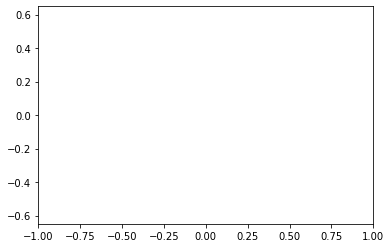

In [334]:
x = np.linspace(0,1,11)
y = np.linspace(1,0,11)
u = v = np.zeros((11,11))
u[5,5] = 0.2
plt.axis('equal')
plt.axis([-1, 1, -1, 1])
plt.quiv
er(0,0, .8, -.33,  color=[(.5, 0, 0)], scale=1)

In [335]:
#Change action set to boundaries
#Check how two thetas with same optimal actions will have different action sequences
#Why are these different? How will these differ?
#Choose different colors and figure out the scale
#check about frequency of "pulls", sum the action sequence!
#Candidate values of theta: alternating signs (like with 0.9, 0.5 as values, a lot of coordinates should differ), alternating signs with only one coord differs
#Exploratory: If you were just solving mab, can you formulat an alternative estimator that is a solution to an lp
#Exploratory: decision variables are unknown means where you have to solve, and every time an arm is pulled, you get a constraint
# You also get other constraints that when an arm is not pulled, you get an equality constraint
#so look at the end of the horizon, and get the lp from there

In [336]:
theta = np.matrix([1, 0])
action_set = np.matrix([generate_random_vec(dim = 2) for _ in range(50)])
oracle = Oracle(theta)
T=10000
alg = UCB(action_set, T=T, dim=2)

alpha = 1/(T * T)
train_alg_UCB(alg, T, theta, oracle)
# print(alg.action_idxs)
rewards = action_set @ theta.T
min_reward = min(rewards)
max_reward = max(rewards)

In [340]:
def gcb(T, alpha, num_samples):
#     np.sqrt((2*np.log(self.T*self.T))/(num_samples + 1)) 
    return np.sqrt((2*np.log(T*T))/num_samples) 

In [341]:
import gurobipy as gp
m = gp.Model()
all_vars = {}
num_pulls = {}

for i in range(len(action_set)):
    num_pulls[i] = []
    
for t in range(T):
    for key in num_pulls.keys():
        if alg.action_idxs[t] != key:
            if t != 0:
                num_pulls[key].append(num_pulls[key][ - 1])
            else:
                num_pulls[key].append(0)
        else:
            if t != 0:
                num_pulls[key].append(num_pulls[key][ - 1] + 1)
            else:
                num_pulls[key].append(1)

for t in range(T):
    for idx, ele in enumerate(action_set):
        if t not in all_vars:
            all_vars[t] = {}
        all_vars[t][idx] = m.addVar(name="u_{}_{}".format(t, idx))
m.setObjective(all_vars[5][0] + all_vars[5][0], gp.GRB.MAXIMIZE)



for t, ele in enumerate(alg.action_idxs):
    for i in range(len(action_set)):
        if i != ele and t >= len(action_set):  
#             print("T: {}, BEST: {}, OTHER: {}, Val: {}".format(t, ele, i, gcb(T, alpha, num_pulls[i][t]) - gcb(T, alpha, num_pulls[ele][t])))
            m.addConstr(all_vars[t][ele] + gcb(T, alpha, num_pulls[ele][t-1]) - all_vars[t][i] - gcb(T, alpha, num_pulls[i][t - 1]) >= 0)
            if t - 1 > -1:
                m.addConstr(all_vars[t][i] - all_vars[t - 1][i] == 0)
        m.addConstr(all_vars[t][i] >= 0)
        m.addConstr(all_vars[t][i] <= 1)



m.optimize()


Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1975100 rows, 500000 columns and 2950200 nonzeros
Model fingerprint: 0xc9fb2d66
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-04, 2e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1647877 rows and 332401 columns
Presolve time: 1.45s

Solved with dual simplex
Solved in 0 iterations and 1.45 seconds (0.41 work units)
Infeasible or unbounded model


In [342]:
true_rewards = rewards = action_set @ theta.T
best_true = max(true_rewards)
best_sample = max(alg.sample_means)
lp_vals = []
for i in range(len(action_set)):
    lp_vals.append(all_vars[T-1][i].X)
best_lp = max(lp_vals)
print(lp_vals)
for idx in range(len(action_set)):
    print("arm {}, Real: {}, Calc: {}, LP: {}".format(idx, best_true - true_rewards[idx], best_sample - alg.sample_means[idx], best_lp - all_vars[T-1][idx].X))

AttributeError: Unable to retrieve attribute 'X'

In [343]:
m.computeIIS()
m.write("model.ilp")

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+30   1.000000e+30   2.000000e+00      3s
   24053    2.0000000e+00   5.173647e+03   0.000000e+00      7s
   31393    2.0000000e+00   1.181956e+03   0.000000e+00     10s
   31598    1.9999935e+00   2.343136e+03   0.000000e+00     15s
   31698    1.9999851e+00   3.573934e+03   0.000000e+00     25s
   31800    1.9999772e+00   7.992726e+03   0.000000e+00     40s

IIS computed: 2114 constraints and 1 bounds
IIS runtime: 55.40 seconds (102.56 work units)


In [215]:
print(alg.confidence_widths)
print(alg.action_idxs)


[0.28591709 0.26929977 0.0669417  0.09579505 0.51544437]
[0, 1, 2, 3, 4, 3, 2, 1, 0, 4, 3, 2, 0, 1, 3, 2, 4, 3, 1, 0, 2, 3, 2, 4, 1, 0, 3, 2, 4, 0, 1, 3, 2, 3, 1, 4, 2, 0, 3, 1, 2, 4, 3, 2, 1, 0, 3, 2, 4, 0, 3, 1, 2, 2, 3, 1, 4, 0, 2, 3, 2, 1, 3, 4, 0, 2, 3, 2, 1, 3, 0, 2, 4, 2, 3, 1, 2, 3, 1, 4, 2, 0, 1, 2, 3, 3, 1, 2, 4, 0, 3, 2, 3, 2, 1, 4, 0, 2, 3, 1, 2, 3, 0, 3, 2, 1, 3, 2, 4, 3, 0, 2, 1, 3, 2, 0, 3, 2, 3, 4, 1, 2, 1, 2, 0, 3, 2, 1, 0, 3, 2, 4, 3, 2, 1, 0, 3, 2, 2, 1, 3, 2, 2, 1, 3, 0, 4, 2, 3, 1, 2, 3, 0, 2, 1, 0, 3, 2, 2, 3, 2, 1, 0, 4, 3, 2, 1, 2, 3, 2, 2, 0, 1, 3, 4, 0, 2, 3, 2, 2, 1, 3, 2, 0, 2, 3, 3, 2, 0, 4, 2, 3, 1, 3, 2, 3, 2, 0, 3, 1, 2, 2, 0, 1, 3, 2, 4, 2, 2, 2, 1, 3, 2, 0, 2, 3, 2, 3, 2, 4, 3, 0, 2, 3, 1, 2, 0, 3, 2, 3, 4, 1, 2, 3, 0, 2, 2, 2, 1, 3, 3, 0, 1, 2, 2, 3, 2, 4, 3, 2, 2, 2, 1, 3, 2, 0, 2, 3, 2, 1, 0, 3, 2, 2, 3, 0, 2, 3, 4, 2, 1, 2, 3, 3, 2, 0, 1, 2, 3, 4, 0, 2, 2, 3, 2, 2, 1, 0, 3, 2, 3, 2, 3, 2, 3, 1, 0, 2, 3, 4, 3, 2, 1, 3, 2, 3, 0, 3, 2, 3, 2, 2, 3, 2, 

In [346]:
print(alg.debug_np[T-1][1])
print(num_pulls[1][T-1])
print(alg.debug_cw[695][27])
print(alg.debug_cw[695][25])
print(alg.debug_np[695][27])
print(num_pulls[27][695])
print(gcb(T, alpha, num_pulls[25][695]))


239
239
1.47212054909006
1.8300859763187662
17
17
1.8300859763187662
